In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This notebook will do the following:

- Will start with an EDA to investigate the data first and see what intutions we can get
- Will run a voting classifier
- Will run a xgboost classfier
- Will run a NN classifier

## EDA

We will start with EDA (Explatory Data Analysis)

In [2]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


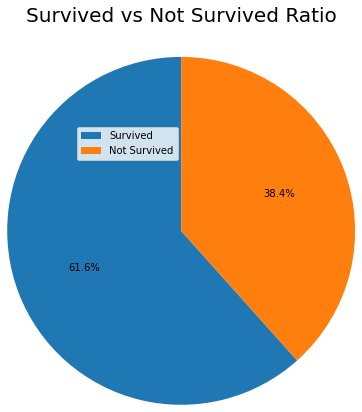

In [6]:
import matplotlib.pyplot as plt
values = df_train['Survived'].value_counts()
plt.pie(values, autopct='%1.1f%%', startangle=90, radius=2)
plt.title('Survived vs Not Survived Ratio', loc = 'center', fontdict ={'size':20},pad=100)
plt.legend(labels=['Survived', 'Not Survived'])

In [7]:
# list missing values per column
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Intuition**
We have missing values on *Age* and *Cabin* columns

In [8]:
def group_by_columns_per_survived(column_name):
    return df_train[[column_name, 'Survived']].groupby([column_name], as_index=False).mean().sort_values(by='Survived', ascending=False)
group_by_columns_per_survived('Pclass')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


**Intuition**

Within the classes:
* 62% of class 1
* 47% of class 2
* 24% of class 3

survivied

In [9]:
group_by_columns_per_survived('Sex')

,Sex,Survived
0,female,0.742038
1,male,0.188908


**Intuition**

74% of females and 18% of males have survived

In [10]:
group_by_columns_per_survived('SibSp')

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


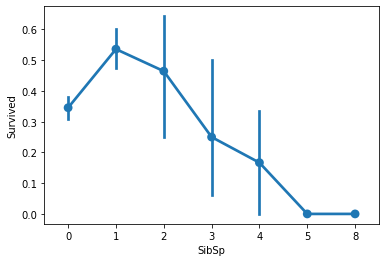

In [11]:
sns.pointplot(x='SibSp', y='Survived', data=df_train)
plt.show()

**Intuition**

People with siblings / spouses aboard the Titanic % of survival of people with 
* 0 siblings: 24
* 1 siblings: 55
* 2 siblings: 50
* 3 siblings: 60
* 4 siblings: 0
* 5 siblings: 20
* 6 siblings: 0

In [12]:
group_by_columns_per_survived('Parch')

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


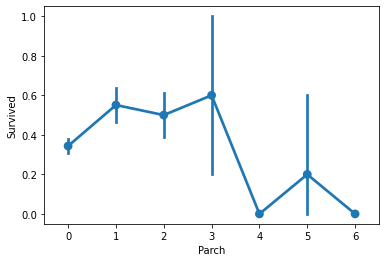

In [13]:
sns.pointplot(x='Parch', y='Survived', data=df_train)
plt.show()

People with parents / children aboard the Titanic

% of survival:

* 0 parent 34
* 1 parent 55
* 2 parent 50
* 3 parent 60
* 4 parent 0
* 5 parent 20
* 6 parent 0

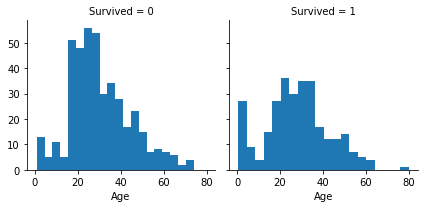

In [14]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

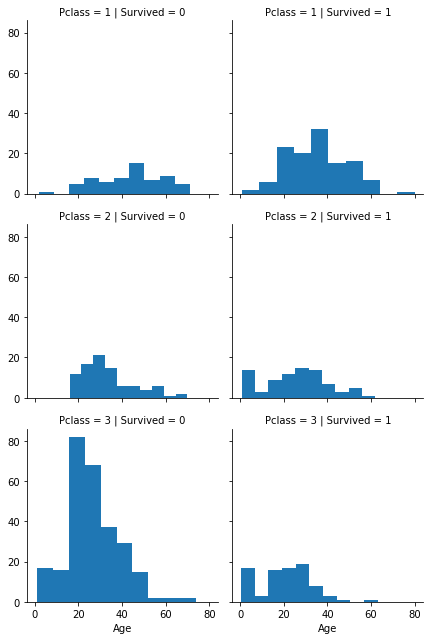

In [15]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age')
grid.add_legend();

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


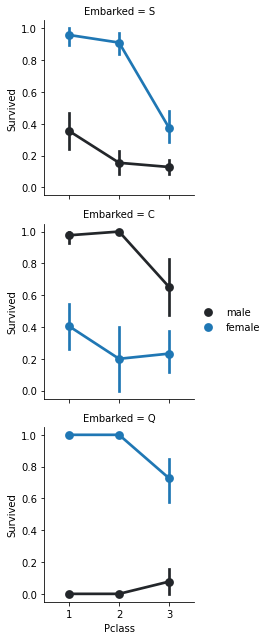

In [16]:
grid = sns.FacetGrid(df_train, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
grid.add_legend()

For embarked C = Cherbourg, Q = Queenstown, S = Southampton

It seems like For Queenstown females mostly survived (has a high survival rate) while Cherborg has the opposite true

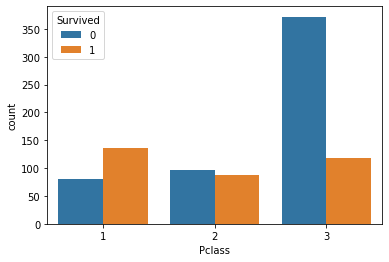

In [17]:
sns.countplot(x='Pclass', hue='Survived', data=df_train)
plt.show()

For all intents and purposes it seems like you are likely to survive if you are at first class. 

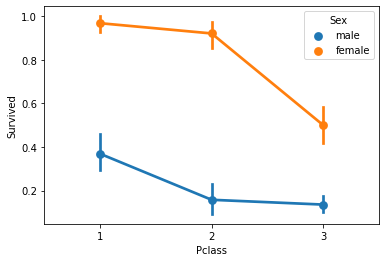

In [18]:
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=df_train)
plt.show()

Woman in first class most likely survived as well

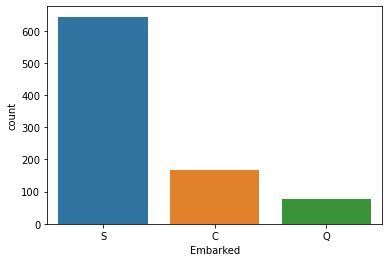

In [19]:
sns.countplot(x='Embarked', data=df_train)
plt.show()

The most common is S for embarked, good idea to fill in with S per default

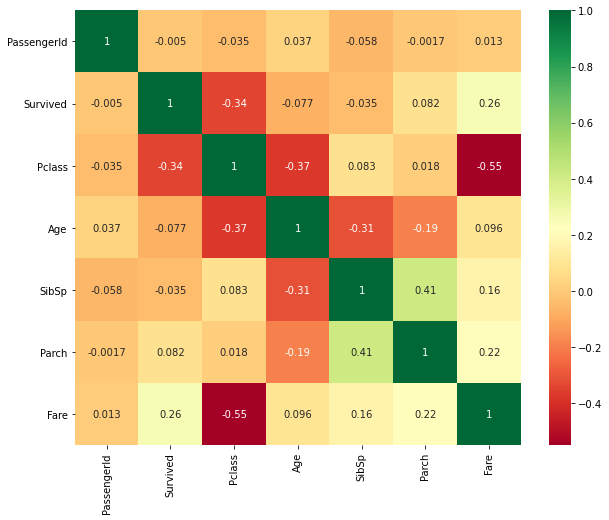

In [20]:
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

High values with max 1 means an increase in 1 means increase in another so in that case we do not need 2 features. Looks like we can just join sibling and parent columns into 1

## Organize Data

Here we will replace values, add features and remove stuff if needed.

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Remove unnecessary features

We can remove the following from the start: 

* Passenger ID is just an id and does not mean much
* Name is irrelevant to us ( we can maybe take a look at the titles the passengers have )
* Ticket is the ticket number and is not relevant to us


In [22]:
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
df_test = df_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


## Handle siblings

We have SibSp and Parch which can be summed up into num_family.

In [24]:
df_train['num_family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['num_family'] = df_test['SibSp'] + df_test['Parch'] + 1

We can also use a boolean value to indicate if the passenger was alone since that is a strong indicator if the passenger survived or not

In [25]:
df_train['is_alone'] = np.where(df_train['num_family'] > 1, 0, 1)
df_test['is_alone'] = np.where(df_test['num_family'] > 1, 0, 1)

In [26]:
df_train['is_alone'].describe()

count    891.000000
mean       0.602694
std        0.489615
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: is_alone, dtype: float64

Lets see how the feature fares

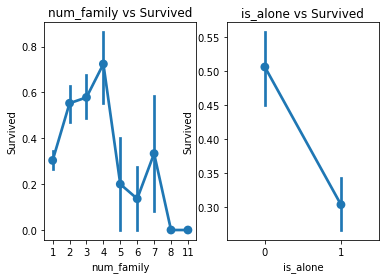

In [27]:
f,ax=plt.subplots(1,2)
sns.pointplot(x='num_family',y='Survived',data=df_train,ax=ax[0])
ax[0].set_title('num_family vs Survived')
sns.pointplot(x='is_alone',y='Survived',data=df_train,ax=ax[1])
ax[1].set_title('is_alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

Being alone or not seems like a better predictor since "is_alone" reflects that survival is better when not alone

In [28]:
df_train = df_train.drop(['SibSp', 'Parch', 'num_family'], axis=1)
df_test = df_test.drop(['SibSp', 'Parch', 'num_family'], axis=1)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
 5   Cabin     204 non-null    object 
 6   Embarked  889 non-null    object 
 7   is_alone  891 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


I will also drop cabin because it has lots of Nan's and we have the information it could give us from other variables like class

In [30]:
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

We should convert categorical values to ints as well

In [31]:
df_train["Sex"] = np.where(df_train["Sex"] == "male", 0, 1)
df_test["Sex"] = np.where(df_test["Sex"] == "male", 0, 1)

Now we need to fill in the nans in embarked. Since the most common Embarked is S we will take it by default

In [32]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

And cast to int

In [33]:
df_train['Embarked'] = df_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
df_test['Embarked'] = df_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

Fill in the age with median value for now

In [34]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())

In [35]:
df_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
is_alone    0
dtype: int64

In [36]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,is_alone
0,0,3,0,22.0,7.2500,0,0
1,1,1,1,38.0,71.2833,1,0
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,0,0
4,0,3,0,35.0,8.0500,0,1


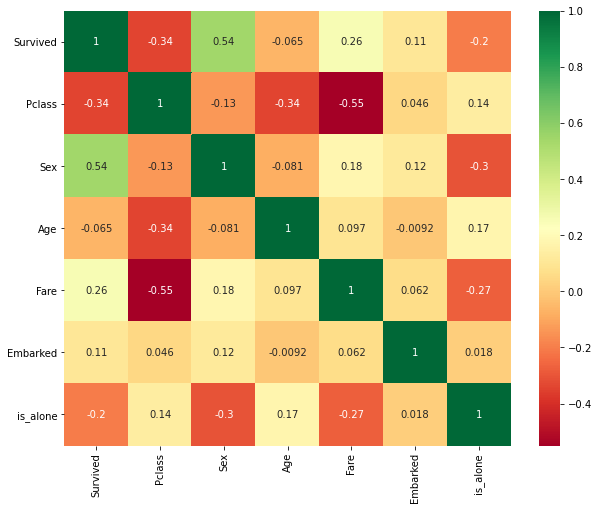

In [37]:
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

For fare we dont really have a need becase higher classes will be more expensive

In [38]:
df_train = df_train.drop(['Fare'], axis=1)
df_test = df_test.drop(['Fare'], axis=1)

## Modeling

First we will prepare the X and y for training the model

In [39]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test = df_test.copy()

Before we start we should create helper methods for validation metrics

In [40]:
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict
)
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

def show_metrics(model, train_x, train_y):
    print('Cross validation score:', cross_val_score(model, train_x, train_y, cv=3, scoring="accuracy"))
    predict_y = cross_val_predict(model, train_x, train_y, cv=3)
    print('Confusion matrix:\n', confusion_matrix(train_y, predict_y))
    print('Precision: ', precision_score(train_y, predict_y), 'Recall:', recall_score(train_y, predict_y), 'F1:', f1_score(train_y, predict_y))
    print('Score', round(model.score(X_train, Y_train) * 100, 2))

In [41]:
# To get a baseline model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, Y_train)

show_metrics(sgd_clf, X_train, Y_train)

Cross validation score: [0.78114478 0.76094276 0.8047138 ]
Confusion matrix:
 [[475  74]
 [120 222]]
Precision:  0.75 Recall: 0.6491228070175439 F1: 0.6959247648902821
Score 73.06


In [42]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

show_metrics(random_forest, X_train, Y_train)

Cross validation score: [0.77104377 0.8047138  0.76430976]
Confusion matrix:
 [[451  98]
 [106 236]]
Precision:  0.7065868263473054 Recall: 0.6900584795321637 F1: 0.6982248520710058
Score 91.58


In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1)
bst.fit(X_train, Y_train)

show_metrics(bst, X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


We can also try to do a randomized search. I took RandomForestClassifier and XGBoost models to start

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(low=1, high=200),
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
}

rnd_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rnd_clf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=32)
rnd_search.fit(X_train, Y_train)

print('Best parameters:', rnd_search.best_params_, 'Best score:', rnd_search.best_score_)

Best parameters: {'bootstrap': True, 'max_depth': 80, 'n_estimators': 90} Best score: 0.7980038917833155


In [45]:
param_dist = {
    'n_estimators': randint(low=1, high=200),
    'learning_rate': [0.0001,0.001, 0.01, 0.1, 1] ,
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
}

bst = XGBClassifier(seed=0, random_state=42, eval_metric='logloss')
rnd_search = RandomizedSearchCV(bst, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=32)
rnd_search.fit(X_train, Y_train)

print('Best parameters:', rnd_search.best_params_, 'Best score:', rnd_search.best_score_)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 60, 'n_estimators': 55} Best score: 0.8182035026049841


Finally we can assemble them in a voting classifier with the best values

In [46]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(bootstrap=True, max_depth=80, n_estimators=90)), 
    ('xg', XGBClassifier(learning_rate=0.1, max_depth=60, n_estimators=55))
], voting='hard')

voting_clf.fit(X_train, Y_train)

show_metrics(voting_clf, X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross validation score: [0.79124579 0.81818182 0.77104377]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix:
 [[499  50]
 [131 211]]
Precision:  0.8084291187739464 Recall: 0.6169590643274854 F1: 0.6998341625207297
Score 90.12


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


With the best parameters we get 90% accuracy with the ensemble method which is great! We can move to final stage now!

## Submission and Conclusion

You can create and submit a csv file in the following way:

In [47]:
#Y_pred = voting_clf.predict(X_test)
#df_submission['Survived'] = Y_pred
#df_submission.to_csv('submission_file.csv', index=False)